<a href="https://colab.research.google.com/github/rahiakela/pytorch-computer-vision-cookbook/blob/main/6-single-object-segmentation/1_single_object_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Single-Object Segmentation

**Object segmentation is the process of finding the boundaries of target objects in images.** There are many applications for segmenting objects in images. As an example, by outlining anatomical objects in medical images, clinical experts can learn useful information about patients' conditions.

Depending on the number of objects in images, we can deal with single-object or multi object segmentation tasks.

In single-object segmentation, we are interested in automatically outlining the boundary of one target object in an image.

The object boundary is usually defined by a binary mask. From the binary mask, we can overlay a contour on the image to outline the object boundary.

As an example, the following screenshot depicts an ultrasound image of a fetus, a binary mask corresponding to the fetal head, and the segmentation of the fetal head overlaid on the ultrasound image:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/single-object-segmentation.png?raw=1' width='800'/>

Other examples include the segmentation of heart chambers in MRI or CT images in order to calculate multiple clinical indices including the ejection fraction.

**The goal of automatic single-object segmentation is to predict a binary mask given in an image.**


In this notebook, we will learn how to create an algorithm to automatically segment a fetal head in ultrasound images. This is an important task in medical imaging in order to measure the fetal head circumference.

So, we will cover the following recipes:

- Creating custom datasets
- Defining the model
- Defining the loss function and optimizer
- Training the model
- Deploying the model


## Setup

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

from albumentations import (
    HorizontalFlip,
    VerticalFlip,    
    Compose,
    Resize,
)

from sklearn.model_selection import ShuffleSplit

from PIL import Image, ImageDraw, ImageFont
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

import copy
import os
import random
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

1.8.0+cu101


## Creating custom datasets

We will use the data from the Automated measurement of fetal head circumference
competition on the Grand Challenge website. During pregnancy, ultrasound imaging is used to measure the fetal head circumference. The measurement can be used to monitor the growth of the fetus. The dataset contains the two-dimensional (2D) ultrasound images of the standard plane.

### Download dataset

To download the dataset, visit https://zenodo.org/record/1322001#.YDN1n-gzY2x and go through the following steps:

1. Download the training_set.zip and test_test.zip files.
2. Move the ZIP files to a folder named data in the same location as your code and extract them as training_set and test_set, respectively. The training_set
folder should contain 1,998 .png files, including 999 images and 999 annotations. In addition, the test_set folder should contain 335 .png images. There are no annotation files in the test_set folder.

We will use the images and annotations in the training_set folder for training
the model.

Then, we will deploy the model on the images in the test_set folder.

In [ ]:
%%shell

# Download the training and test set
wget https://zenodo.org/record/1322001/files/training_set.zip
wget https://zenodo.org/record/1322001/files/test_set.zip

# extract zip file
unzip training_set.zip
unzip test_set.zip

# Create a folder named data
mkdir data

# copy the training and test set to data directory
cp -r training_set data
cp -r test_set data

# delete all zip file
rm -rf training_set.zip test_set.zip

we will explore the data, define augmentation functions, and create the
custom datasets.

### Data exploration

We inspected the data to understand more about it. First,
we got the list of images and annotations in the training_set folder. The annotations files have the term Annotation in the filename.

We will first explore the data and display a few sample images and masks:

1. Let's inspect the training_set folder by counting the number of images and
annotations:

In [5]:
train_path = "./data/training_set/"

imgs_list = [pp for pp in os.listdir(train_path) if "Annotation" not in pp]
annotations_list = [pp for pp in os.listdir(train_path) if "Annotation" in pp]

print("number of images:", len(imgs_list))
print("number of annotations:", len(annotations_list))

number of images: 1000
number of annotations: 999


2. Next, we will display a few sample images and masks:

In [6]:
np.random.seed(2021)
rnd_images = np.random.choice(imgs_list, 4)
rnd_images

array(['478_HC.png', '906_HC.png', '645_HC.png', '474_HC.png'],
      dtype='<U11')

Now let's show an image and its annotation.

In [7]:
def show_img_mask(img, mask):
  if torch.is_tensor(img):
    img = to_pil_image(img)
    mask = to_pil_image(mask)

  img_mask = mark_boundaries(np.array(img), np.array(mask), outline_color=(0, 1, 0), color=(0, 1, 0))
  plt.imshow(img_mask)

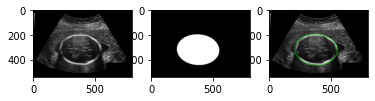

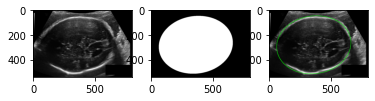

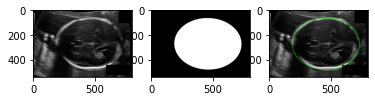

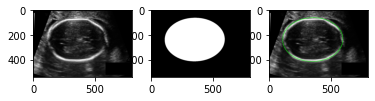

In [8]:
for img in rnd_images:
  img_path = os.path.join(train_path, img)
  annot_path = img_path.replace(".png", "_Annotation.png")

  img = Image.open(img_path)
  annt_edges = Image.open(annot_path)

  mask = ndi.binary_fill_holes(annt_edges)

  plt.figure()
  plt.subplot(1, 3, 1) 
  plt.imshow(img, cmap="gray")

  plt.subplot(1, 3, 2) 
  plt.imshow(mask, cmap="gray")

  plt.subplot(1, 3, 3) 
  show_img_mask(img, mask)

(-0.5, 799.5, 539.5, -0.5)

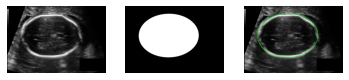

In [9]:
plt.figure()
plt.subplot(1, 3, 1) 
plt.imshow(img, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(mask, cmap="gray")
plt.axis('off')    

plt.subplot(1, 3, 3) 
show_img_mask(img, mask)
plt.axis('off')

### Data augmentation

In the Data augmentation, we used a popular Python package called
albumentations for data transformation.

Next, for the training dataset, we composed a vertical and horizontal flip,
resizing the images to 128 x 192. For the validation dataset, we only performed the resizing transformation. We will pass these transformations to the PyTorch dataset class in the next subsection.

In [10]:
h, w = 128, 192

# Define transform_train for the training dataset:
transform_train = Compose([Resize(h, w), HorizontalFlip(p=0.5), VerticalFlip(p=0.5),])

# Define transform_val for the validation dataset:
transform_val = Resize(h, w)

### Creating the datasets

In Creating the dataset class, we used the Dataset class from
the torch.utils.data package to create custom training and validation datasets.

In [11]:
class FetalDataset(Dataset):

  def __init__(self, data_path, transform=None):
    imgs_list = [pp for pp in os.listdir(data_path) if "Annotation" not in pp]
    annotations_list = [pp for pp in os.listdir(train_path) if "Annotation" in pp]

    self.imgs_path = [os.path.join(data_path, fn) for fn in imgs_list]
    self.annots_path = [p2i.replace(".png", "_Annotation.png") for p2i in self.imgs_path]
    self.transform = transform

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    img_path = self.imgs_path[idx]
    image = Image.open(img_path)

    annot_path = self.annots_path[idx]
    annot_edges = Image.open(annot_path)
    mask = ndi.binary_fill_holes(annot_edges)

    image = np.array(image)
    mask = mask.astype("uint8")

    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented["image"]
      mask = augmented["mask"]

    image = to_tensor(image)
    mask = 255 * to_tensor(mask)

    return image, mask

Let's define two objects of the fetal_dataset class

In [12]:
fetal_dataset1 = FetalDataset(train_path, transform=transform_train)
fetal_dataset2 = FetalDataset(train_path, transform=transform_val)

print(len(fetal_dataset1))
print(len(fetal_dataset2))

1000
1000


Let's fetch a sample image and mask from the feta_ds1 and display it:

In [13]:
img, mask = fetal_dataset1[0]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


Now display the image and mask:

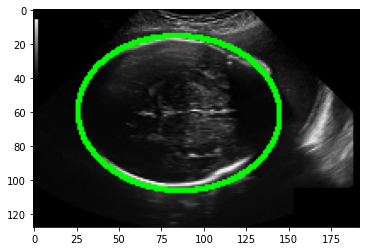

In [14]:
show_img_mask(img, mask)

### Split data into training and validation set

We created two lists of train_index and val_index by separating 20 percent of
the indices from the total indices.

In [15]:
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(fetal_dataset1))
for train_index, val_index in sss.split(indices):
  print(len(train_index))
  print("-" * 10)
  print(len(val_index))

800
----------
200


In [16]:
# Create train_ds and val_ds
train_ds = Subset(fetal_dataset1, train_index)
print(len(train_ds))

val_ds = Subset(fetal_dataset2, val_index)
print(len(val_ds))

800
200


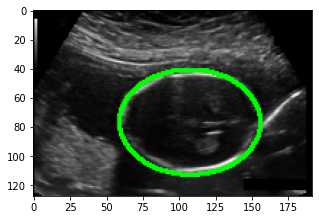

In [17]:
# Show a sample image from train_ds
plt.figure(figsize=(5, 5))

for img, mask in train_ds:
  show_img_mask(img, mask)
  break

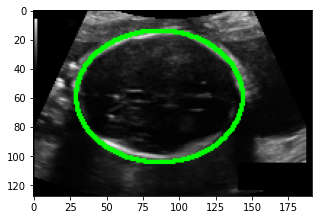

In [18]:
# Show a sample image from val_ds
plt.figure(figsize=(5, 5))

for img, mask in val_ds:
  show_img_mask(img, mask)
  break

### Define the data loaders

We defined two data loaders, `train_dataloader` and `val_dataloader`, using the DataLoader class to be able to fetch data batches from the training and validation datasets during training.

In [19]:
# define train dataloader
train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=16, shuffle=False)

We got a data batch from `train_dataloader` and `val_dataloader` and printed their respective shapes. As we saw, tensors of size `[batch_size, 128, 192]` were returned from the data loaders.

In [20]:
for img_b, mask_b in train_dataloader:
  print(img_b.shape,img_b.dtype)
  print(mask_b.shape, mask_b.dtype)
  break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [21]:
for img_b, mask_b in val_dataloader:
  print(img_b.shape,img_b.dtype)
  print(mask_b.shape, mask_b.dtype)
  break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


In [22]:
torch.max(img_b)

tensor(0.9961)

## Defining the model

The YOLO-v3 network is built of convolutional layers with stride 2, skip connections, and up-sampling layers. There are no pooling layers. The network receives an image whose size is 416*416 as input and provides three YOLO outputs.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/yolo-v3.png?raw=1' width='800'/>

The network down-samples the input image by a factor of 32 to a feature map of
size `13*13`, where `yolo-out1` is provided. To improve the detection performance, the `13*13` feature map is up-sampled to `26*26` and `52*52`, where we have `yolo-out2` and `yolo-out3`, respectively. A cell in a feature map predicts three bounding boxes that correspond to three predefined anchors. As a result, the network predicts `13*13*3+26*26*3+52*52*3=10647` bounding boxes in total.

A bounding box is defined using 85 numbers:
- Four coordinates, `[x, y, w, h]`
- An abjectness score
- `C=80` class predictions corresponding to 80 object categories in the COCO
dataset




## Training the model

The training process will follow the standard stochastic gradient descent (SGD) process. We will train the model on the training data and evaluate it on the validation data. Due to the large size of the COCO dataset and our deep model of the YOLO-v3 architecture, training will be very slow, even when using a GPU. You may need to train the model for up to a week to get good performance.

In [ ]:
def loss_epoch(model, params_loss, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  len_data = len(dataset_dl.dataset)
  running_metrics = {}

  for xb, yb, _ in dataset_dl:
    yb = yb.to(device)
    _, output = model(xb.to(device))
    loss_b = get_loss_batch(output, yb, params_loss, opt)
    running_loss += loss_b
    if sanity_check is True:
      break
  
  loss = running_loss / float(len_data)

  return loss 

In [ ]:
def train_val(model, params):
  num_epochs=params["num_epochs"]
  params_loss=params["params_loss"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  loss_history = {
      "train": [],
      "val": [],
  }

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float("inf")

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
    model.train()
    train_loss = loss_epoch(model, params_loss, train_dl, sanity_check, opt)
    loss_history["train"].append(train_loss)
    print("train loss: %.6f" %(train_loss))

    model.eval()
    with torch.no_grad():
      val_loss = loss_epoch(model, params_loss, val_dl, sanity_check)
    loss_history["val"].append(val_loss)
    print("val loss: %.6f" %(val_loss))

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print("Loading best model weights!")
      model.load_state_dict(best_model_wts) 
    print("-"*10) 
  
  model.load_state_dict(best_model_wts)

  return model, loss_history

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
      return param_group['lr']

In [ ]:
# let's define the optimizer
# use the learning scheduler to monitor the loss and reduce the learning rate in the case of plateaus.
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, verbose=1)

model_path = "./models/"
if not os.path.exists(model_path):
  os.mkdir(model_path)

scaled_anchors = [
    model.module_list[82][0].scaled_anchors,
    model.module_list[94][0].scaled_anchors,
    model.module_list[106][0].scaled_anchors               
]

In [ ]:
import torch.nn as nn

In [ ]:
# Then, we will set the loss parameters
mse_loss = nn.MSELoss(reduction="sum")
bce_loss = nn.BCELoss(reduction="sum")
params_loss = {
    "scaled_anchors" : scaled_anchors,
    "ignore_thres": 0.5,
    "mse_loss": mse_loss,
    "bce_loss": bce_loss,
    "num_yolos": 3,
    "num_anchors": 3,
    "obj_scale": 1,
    "noobj_scale": 100,
}

# Next, we will set the training parameters
params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dataloader,
    "val_dl": val_dataloader,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": model_path +"weights.pt",
}

Depending on your computer's capability, you may get an out-of-memory error while running the preceding snippet.

>>If you get an out of memory error on your computer, try to reduce the
batch size and restart the notebook.



In [ ]:
model, loss_hist=train_val(model, params_train)

Epoch 0/99, current lr=0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/pytho

train loss: 55.140422
val loss: 1299.523000
Copied best model weights!
----------
Epoch 1/99, current lr=0.001
train loss: 55.633263
val loss: 1302.807200
----------
Epoch 2/99, current lr=0.001
train loss: 55.060556
val loss: 1284.713000
Copied best model weights!
----------
Epoch 3/99, current lr=0.001
train loss: 55.522496
val loss: 1282.980700
Copied best model weights!
----------
Epoch 4/99, current lr=0.001
train loss: 55.382283
val loss: 1283.549200
----------
Epoch 5/99, current lr=0.001
train loss: 55.382684
val loss: 1300.907000
----------
Epoch 6/99, current lr=0.001
train loss: 55.315766
val loss: 1254.538000
Copied best model weights!
----------
Epoch 7/99, current lr=0.001
train loss: 55.543347
val loss: 1272.445600
----------
Epoch 8/99, current lr=0.001
train loss: 55.105386
val loss: 1303.249700
----------
Epoch 9/99, current lr=0.001
train loss: 55.327308
val loss: 1311.022900
----------
Epoch 10/99, current lr=0.001
train loss: 55.782840
val loss: 1273.420000
-------

## Deploying the model

Now that training is complete, it is time to deploy the model. To deploy the model, we need to define the model class, as described in the Creating the YOLOv3 model recipe. Then, we need to load the trained weights into the model and deploy it on the validation dataset.

In this recipe, you will learn how to load weights into the model, deploy it on a sample image, and display the results.

1. Load trained weights into the model:

In [ ]:
weights_path = "./models/weights.pt"
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

2. Get a sample image from the validation dataset:

In [ ]:
img, tag, _ = coco_val[4]
print(img.shape)
print(tag.shape)

torch.Size([3, 416, 416])
torch.Size([2, 6])


3. Let's display the image and its bounding boxes:

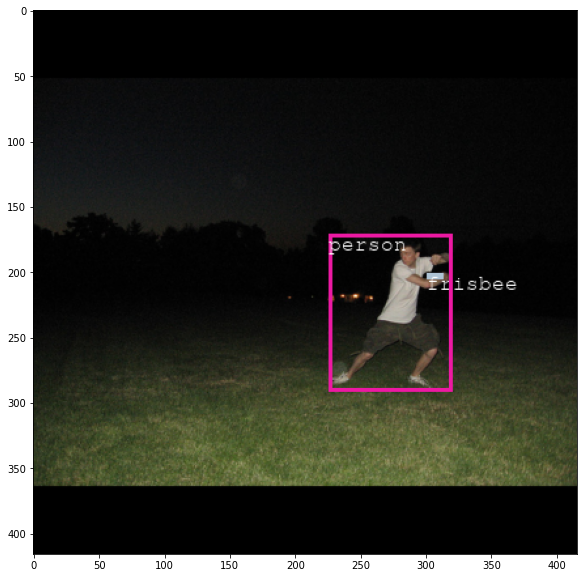

In [ ]:
show_img_bbox(img, tag)

As we can see, the image has a person and a frisbee.

4. Now, let's feed the image to the model to get the output:

In [ ]:
model.eval()
with torch.no_grad():
  out, _ = model(img.unsqueeze(0).to(device))
print(out.shape)

torch.Size([1, 10647, 85])


5. Pass the model's output to the NonMaxSuppression function:

In [ ]:
def NonMaxSuppression(bbox_pred, obj_threshold=0.5, nms_thres=0.5):
  bbox_pred[..., :4] = xywh2xyxy(bbox_pred[..., :4])
  output = [None] * len(bbox_pred)

  for ind, bb_pr in enumerate(bbox_pred):
      bb_pr = bb_pr[bb_pr[:, 4] >= obj_threshold]
      
      if not bb_pr.size(0):
          continue
          
      score = bb_pr[:, 4] * bb_pr[:, 5:].max(1)[0]
      bb_pr = bb_pr[(-score).argsort()]
      
      cls_probs, cls_preds = bb_pr[:, 5:].max(1, keepdim=True)
      detections = torch.cat((bb_pr[:, :5], 
                              cls_probs.float(), 
                              cls_preds.float()), 1)
      
      bbox_nms = []
      while detections.size(0):
          high_iou_inds = bbox_iou(detections[0, :4].unsqueeze(0), 
                                    detections[:, :4]) > nms_thres
          
          cls_match_inds = detections[0, -1] == detections[:, -1]
          supp_inds = high_iou_inds & cls_match_inds
          
          ww = detections[supp_inds, 4]
          # updated accoring to https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/issues/6
          detections[0, :4] = (ww.view(-1, 1) * detections[supp_inds, :4]).sum(0) / ww.sum()
          
          bbox_nms += [detections[0]]
          detections = detections[~supp_inds]
          
      if bbox_nms:
          output[ind] = torch.stack(bbox_nms)
          output[ind]=xyxyh2xywh(output[ind])
  return output

In [ ]:
def xywh2xyxy(xywh):
  xyxy = xywh.new(xywh.shape)
  xyxy[..., 0] = xywh[..., 0] - xywh[..., 2] / 2.0
  xyxy[..., 1] = xywh[..., 1] - xywh[..., 3] / 2.0
  xyxy[..., 2] = xywh[..., 0] + xywh[..., 2] / 2.0
  xyxy[..., 3] = xywh[..., 1] + xywh[..., 3] / 2.0
  return xyxy

In [ ]:
def xyxyh2xywh(xyxy, image_size=416):
  xywh = torch.zeros(xyxy.shape[0],6)
  xywh[:,2] = (xyxy[:, 0] + xyxy[:, 2]) / 2./img_size
  xywh[:,3] = (xyxy[:, 1] + xyxy[:, 3]) / 2./img_size
  xywh[:,5] = (xyxy[:, 2] - xyxy[:, 0])/img_size 
  xywh[:,4] = (xyxy[:, 3] - xyxy[:, 1])/img_size
  xywh[:,1]= xyxy[:,6]    
  return xywh

In [ ]:
def bbox_iou(box1, box2):
  b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
  b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
  inter_rect_x1 = torch.max(b1_x1, b2_x1)
  inter_rect_y1 = torch.max(b1_y1, b2_y1)
  inter_rect_x2 = torch.min(b1_x2, b2_x2)
  inter_rect_y2 = torch.min(b1_y2, b2_y2)
  inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) \
                  *torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
  b1_area = (b1_x2 - b1_x1 + 1.0) * (b1_y2 - b1_y1 + 1.0)
  b2_area = (b2_x2 - b2_x1 + 1.0) * (b2_y2 - b2_y1 + 1.0)
  iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
  return iou

In [ ]:
img_size = 416
out_nms = NonMaxSuppression(out.cpu())
print(out_nms[0].shape)

torch.Size([1667, 6])


6. Let's show the image and predicted bounding box:

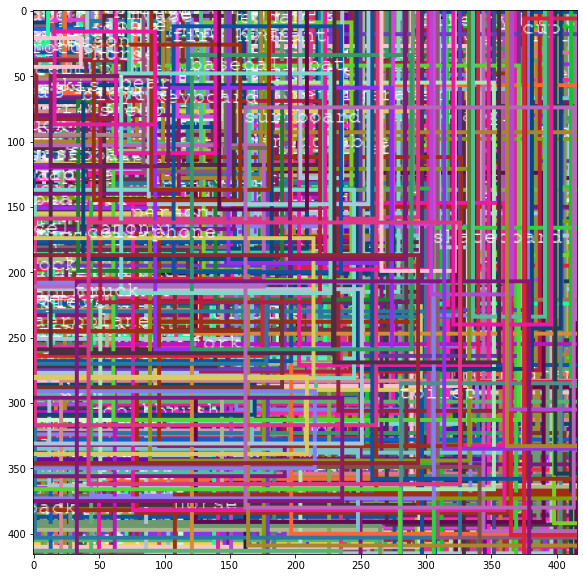

In [ ]:
show_img_bbox(img, out_nms[0])